<a href="https://colab.research.google.com/github/matt24ck/ds-projects/blob/main/CA4015_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Prediction with Random Forest and AutoML

**Objective**: 
1. Use a Random Forest machine learning model to predict whether or not a person has diabetes.
2. Use an AutoML approach to perform the same task.
3. Compare and evaluate the efficacy of both models.

## The Data
This data has been collected by the Logistics Management Institutet,
the National Institute of Diabetes Digestive and Kidney Diseases:
Epidemiology and Data Systems Program,
the Diabetes and Arthritis Epidemiology Section, and
The Johns Hopkins University School of Medicine

The data was collected from the Pima Indian society in Arizona. [1]

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Data Processing

To prepare the dataset for training an ML model, there are a few errors and oddities in the dataset that need to be fixed/eliminated. 

Initially, I need to search for incorrect/null values. *Incorrect* values in this context are outlying values that would be highly medically unlikely, or impossible. (E.g, a BMI of 73 or a # of pregnancies at 200)


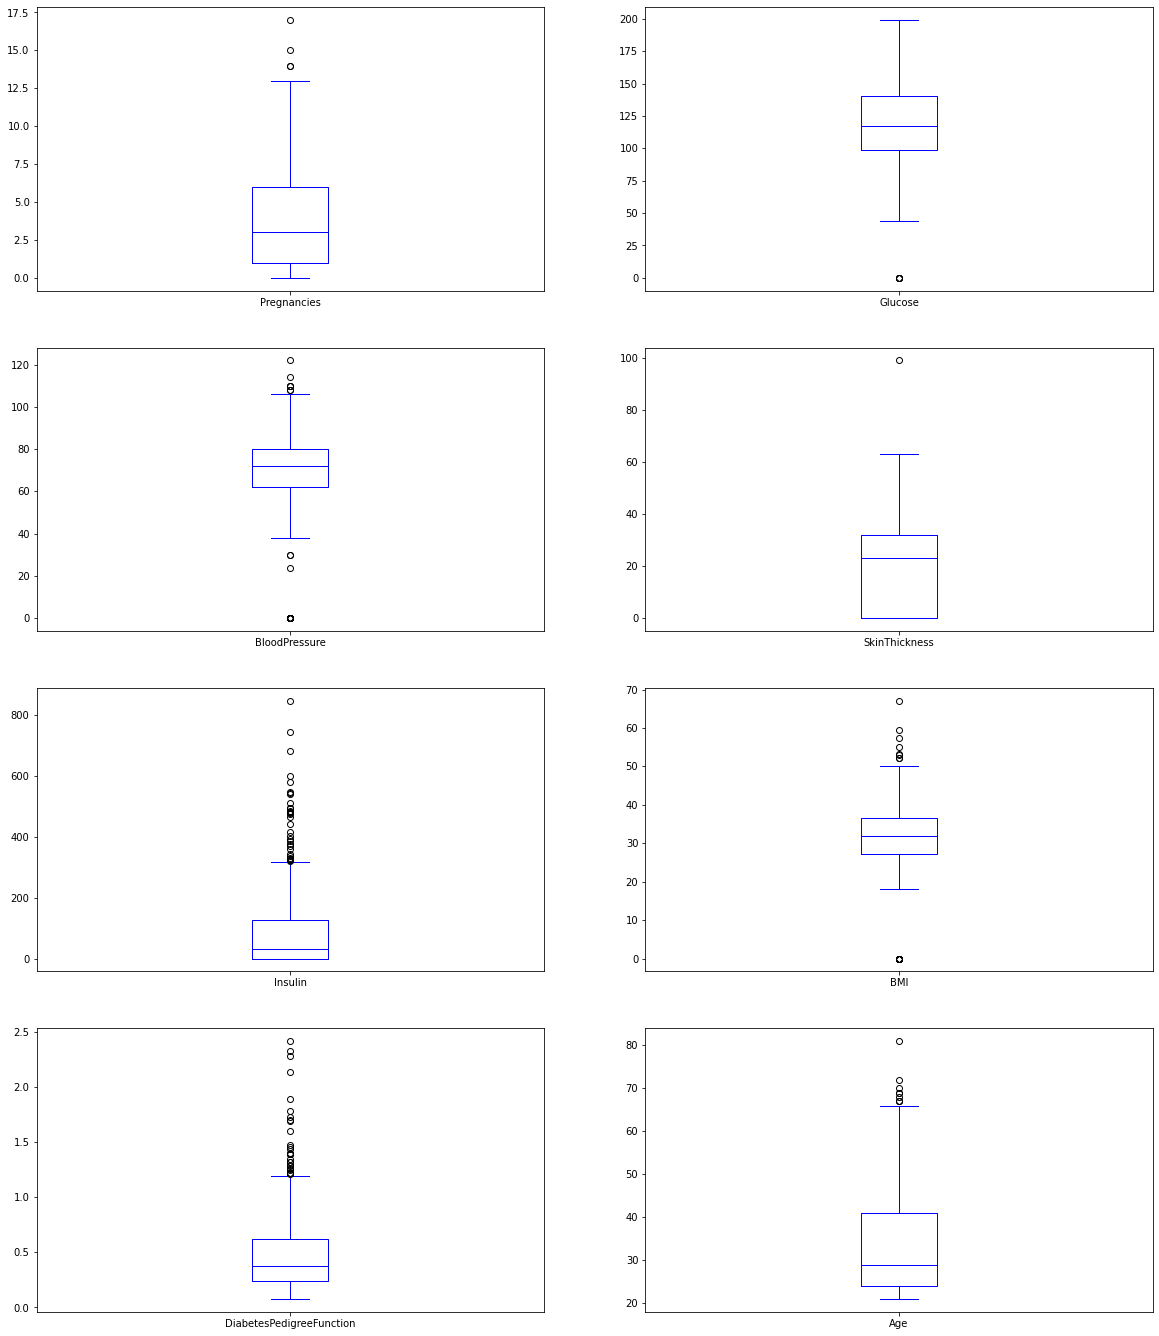

In [ ]:
fig = plt.figure(figsize=(48,24))

ax0 = fig.add_subplot(4,2,1)
ax1 = fig.add_subplot(4,2,2)
ax2 = fig.add_subplot(4,2,3)
ax3 = fig.add_subplot(4,2,4)
ax4 = fig.add_subplot(4,2,5)
ax5 = fig.add_subplot(4,2,6)
ax6 = fig.add_subplot(4,2,7)
ax7 = fig.add_subplot(4,2,8)


#Subplot 
df[["Pregnancies"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax0)
df[["Glucose"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax1)
df[["BloodPressure"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax2)
df[["SkinThickness"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax3)
df[["Insulin"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax4)
df[["BMI"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax5)
df[["DiabetesPedigreeFunction"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax6)
df[["Age"]].plot(kind="box", color="blue", vert=True, figsize=(20,24), ax=ax7)

plt.show()

### Observations

There seem to be a lot of 0 values in features that shouldn't have 0 as values, e.g glucose, Blood Pressure, Skin Thickness, INsulin and BMI. To resolve this, I'll replace those values with more appropriate ones.

To do this, I'll:

1) Replace all the O's with NaN-types

2) Fill the NaN's with whichever value is the most appropriate out of mean, median and mode

In [15]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)#
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77fe508dd0>,
      dtype=object)

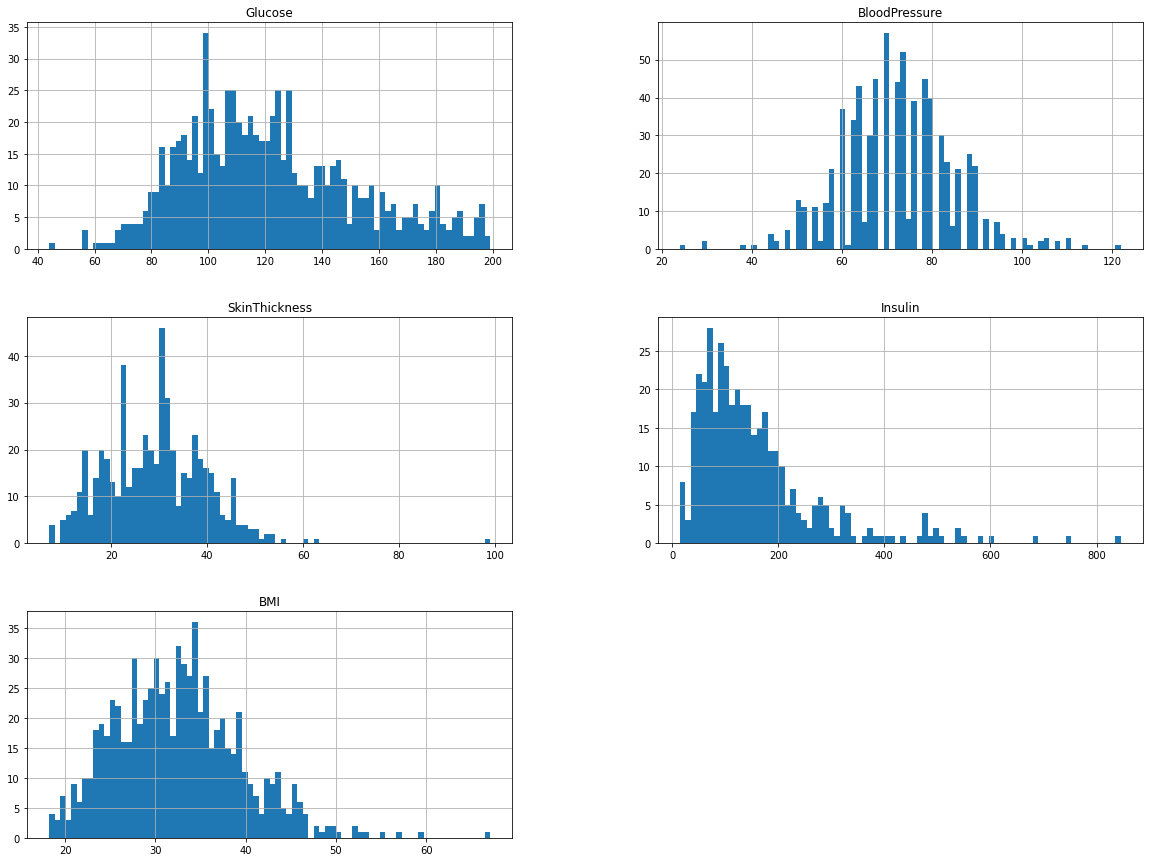

In [ ]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].hist(bins=80, figsize=(20,15))


In [16]:
# Calculate skewness to decide whether to use median or mean
print(df.skew(axis=0))

Pregnancies                 0.901674
Glucose                     0.530989
BloodPressure               0.134153
SkinThickness               0.690619
Insulin                     2.166464
BMI                         0.593970
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64


By the appearance of the distributions of the values in the above 5 columns, and verified by the calculation of skewness, I can deduce:

**Glucose**: Moderately skewed

**Bloodpressure**: Symmetrical

**Skin Thickness**: Moderately Skewed

**Insulin**: Strongly Skewed

Therefore, I will use mean to fill out the null values in *Blood Pressure* and medians for the rest.

In [17]:
df[['Glucose','SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'SkinThickness', 'Insulin', 'BMI']].fillna(df[['Glucose', 'SkinThickness', 'Insulin', 'BMI']].median())
df[["BloodPressure"]] = df[["BloodPressure"]].fillna(df[["BloodPressure"]].mean())

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.405184,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096346,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
#re-check for null values
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Feature Engineering

Some features in the dataset, such as BMI, can be assigned to categories that are pre-determined by medicine. [2] [3]

As such, to improve the accuracy of the model by limiting the decisions in the trees in the random forest, I will assign categories to the values in theses features.

I will use label encoding here as these features have a natural ordering to them, rather than one-hot encoding.

In [19]:
new_cat = "BMICategorical"
df.loc[(df['BMI'] < 18.5), new_cat] = 0
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 24), new_cat] = 1
df.loc[(df['BMI'] >= 24) & (df['BMI'] < 30), new_cat] =  2
df.loc[(df['BMI'] >= 30), new_cat] = 3
df.drop('BMI', axis=1, inplace=True)
df[new_cat] = df[new_cat].astype('category')

new_cat1 = "GlucoseCategorical"
df.loc[(df['Glucose'] < 70), new_cat1] = 0
df.loc[(df['Glucose'] >= 70) & (df['Glucose'] < 140), new_cat1] = 1
df.loc[(df['Glucose'] >= 140) & (df['Glucose'] < 199), new_cat1] = 2
df.loc[(df['Glucose'] >= 200), new_cat1] = 3
df[new_cat1] = df[new_cat1].astype('category')



In [20]:
print(df.isnull().sum())
df[["GlucoseCategorical"]] = df[["GlucoseCategorical"]].fillna(1.0)
print(df.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
BMICategorical              0
GlucoseCategorical          1
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
BMICategorical              0
GlucoseCategorical          0
dtype: int64


## Model Training
### Random Forest

In [21]:
from sklearn.model_selection import train_test_split
rndm_state = 7

#df.drop(columns="Glucose", inplace=True)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rndm_state)

### Notes / Hyperparameter Tuning

Given that I am trying to predict whether or not someone has diabetes, the best model I can design would be the model that reduces the amount of false negatives as much as possible.

Therefore, I will be aiming to maximise the **recall** with this task.

I will be using Grid Search Cross Validation to tune hyperparameters to make the most accurate Random Forest model.
I decided to leave the number of folds at 5 for this model, given the size of the dataset.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

from sklearn.model_selection import GridSearchCV


In [23]:
random_forest = RandomForestClassifier()
grid = {"n_estimators": [250, 350, 450, 550],
        "max_leaf_nodes": [13, 14, 15, 16]}

grid_search = GridSearchCV(random_forest, 
                              param_grid=grid,
                              scoring='recall',
                              cv=3,
                              return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_leaf_nodes': 16, 'n_estimators': 450}

In [24]:
print(recall_score(y_test, grid_search.predict(X_test)))
print(accuracy_score(y_test, grid_search.predict(X_test)))

0.631578947368421
0.7792207792207793


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(y_test, rf.predict(X_test)))

[[87 10]
 [26 31]]


### AutoML - PyCaret

How is AutoML implemented?
The method of applying machine learning to practical issues is known as automated machine learning, or AutoML. From starting with a blank dataset to creating a machine learning model that is ready for deployment, AutoML may cover any step in between. An AI-based solution, called AutoML, was put up as a means of addressing the increased difficulty of using machine learning. With AutoML's high level of automation, non-experts can employ machine learning models and techniques without having to become specialists in the field. Additional benefits of automating machine learning end-to-end include simpler solutions, quicker solution production, and models that frequently outperform manually created models.


In [37]:
df1 = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
df1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [1]:
!pip3 install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


For training the model, I used the following pycaret package:
`pycaret.classification`


In [32]:
from pycaret.classification import *

For data processing, filling in the NaN values was very simple. All a user has to do is add parameters to the `setup()` function. In particular in this case, I used a LightGBM iterative imputer to further investigate the differences between AutoML and my Random Forest model. The parameters I altered were `numeric_imputation` and `imputation_type`.


In [36]:
clf = setup(data=df1, target="Outcome", numeric_imputation="median", imputation_type="iterative")

,Description,Value
0,session_id,1829
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Outcome',
                                      time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_bytre...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
!pip3 install autoviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Exploratory Data Analysis

For performing exploratory data analysis, I used the `eda()` function. I experimented with passing various style parameters, such as *bokeh* and *seaborn* and I felt as though the *seaborn* visualisations provided some more insight. I found the `eda()` function particularly useful for exploring the correlation between features in the dataset, such as confirming the intuitive correlation between BMI and Skin Thickness and noting that the distribution of “Outcome” was somewhat imbalance, there were nearly twice as many healthy people as diabetic people.


INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=data_before_preprocess)
INFO:logs:Global variable: data_before_preprocess returned as      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93         

Shape of your Data Set loaded: (768, 9)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
Data cleaning improvement suggestions. Complete them before proceeding to ML modeling.


,Nuniques,dtype,Nulls,Nullpercent,NuniquePercent,Value counts Min,Data cleaning improvement suggestions
DiabetesPedigreeFunction,517,float64,0,0.000000,67.317708,0,skewed: cap or drop outliers
BMI,248,float64,0,0.000000,32.291667,0,
Insulin,186,int64,0,0.000000,24.218750,0,
Glucose,136,int64,0,0.000000,17.708333,0,
Age,52,int64,0,0.000000,6.770833,0,
SkinThickness,51,int64,0,0.000000,6.640625,0,
BloodPressure,47,int64,0,0.000000,6.119792,0,
Pregnancies,17,int64,0,0.000000,2.213542,0,


    8 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification problem #####################


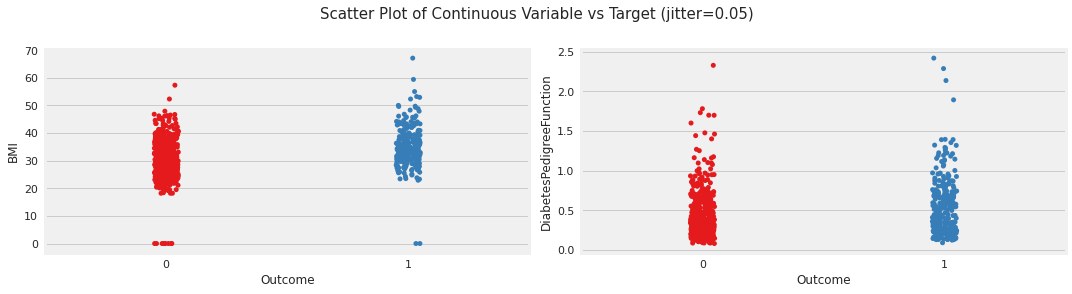

Total Number of Scatter Plots = 3


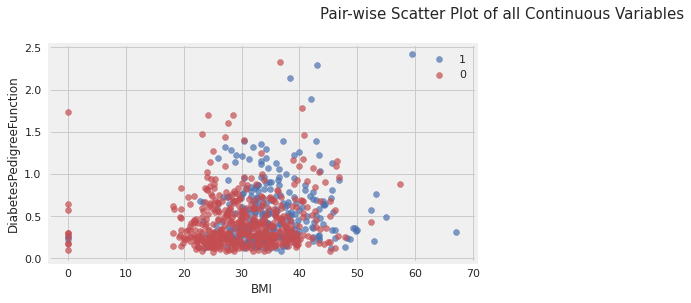

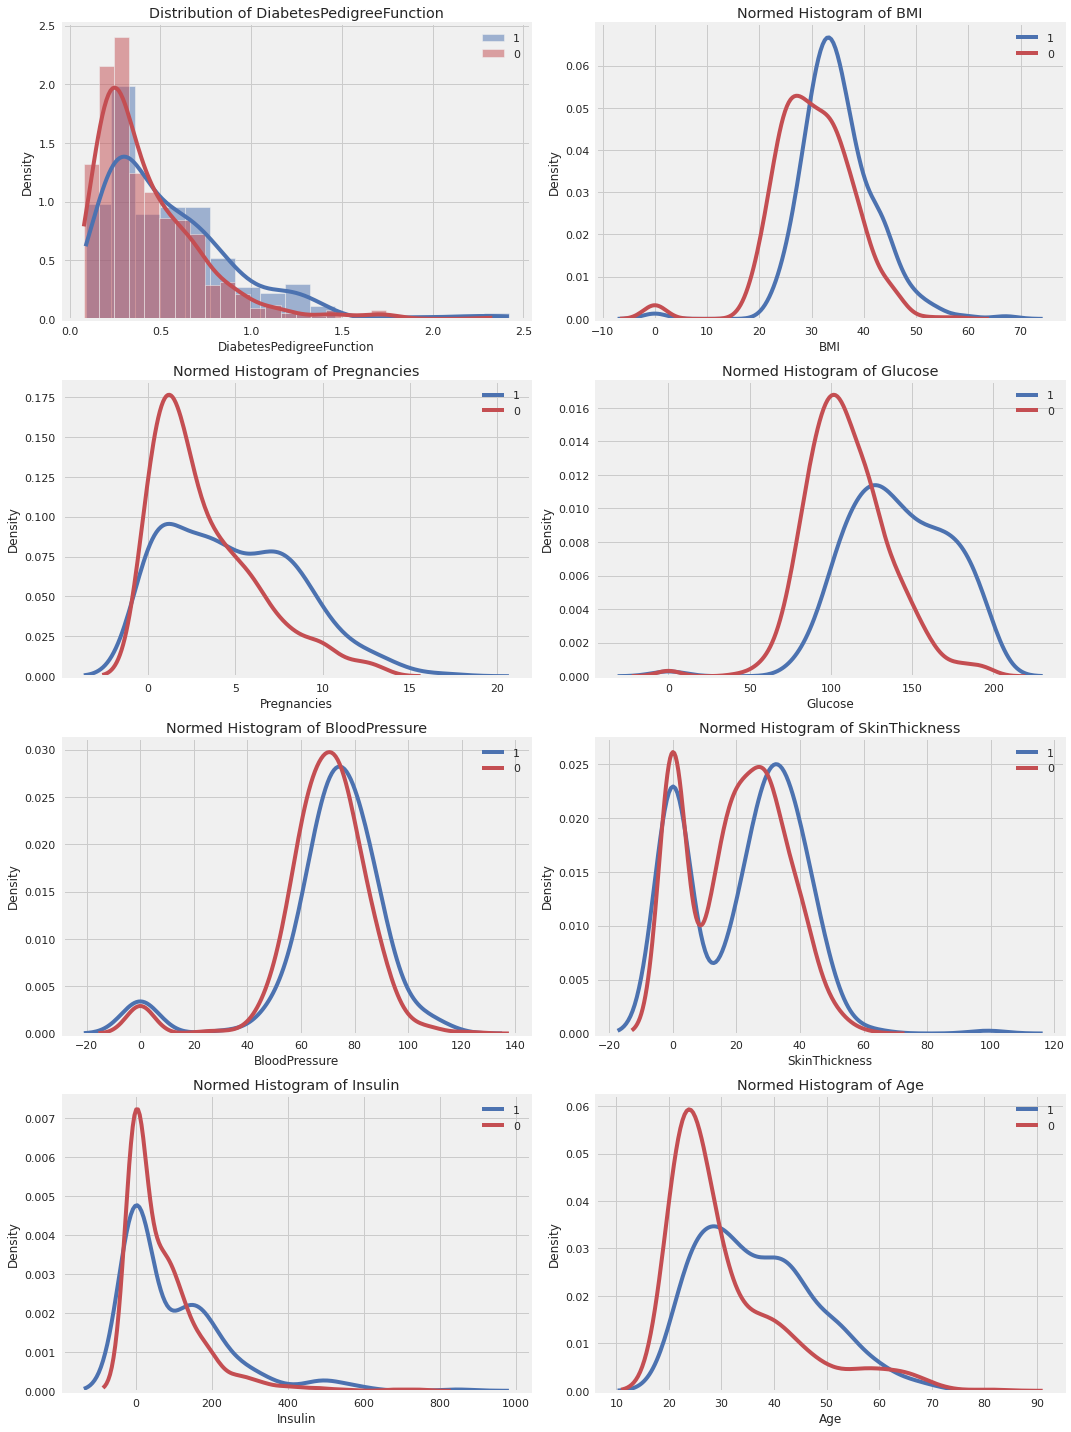

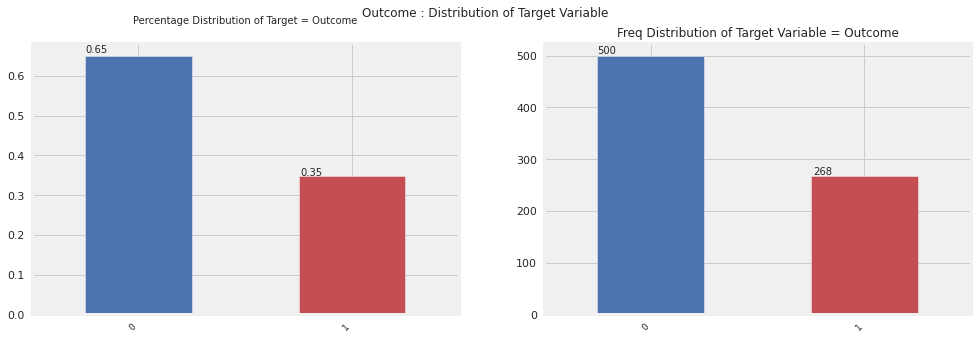

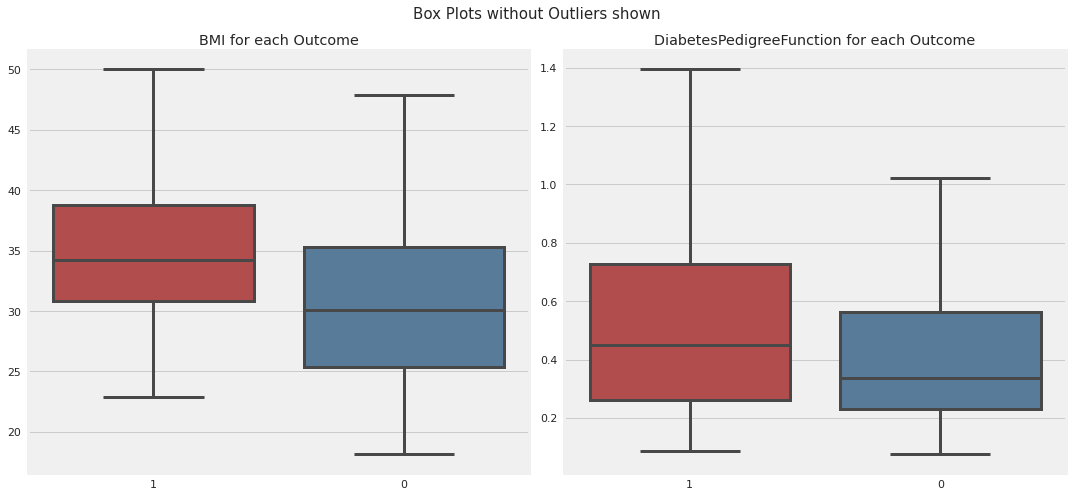

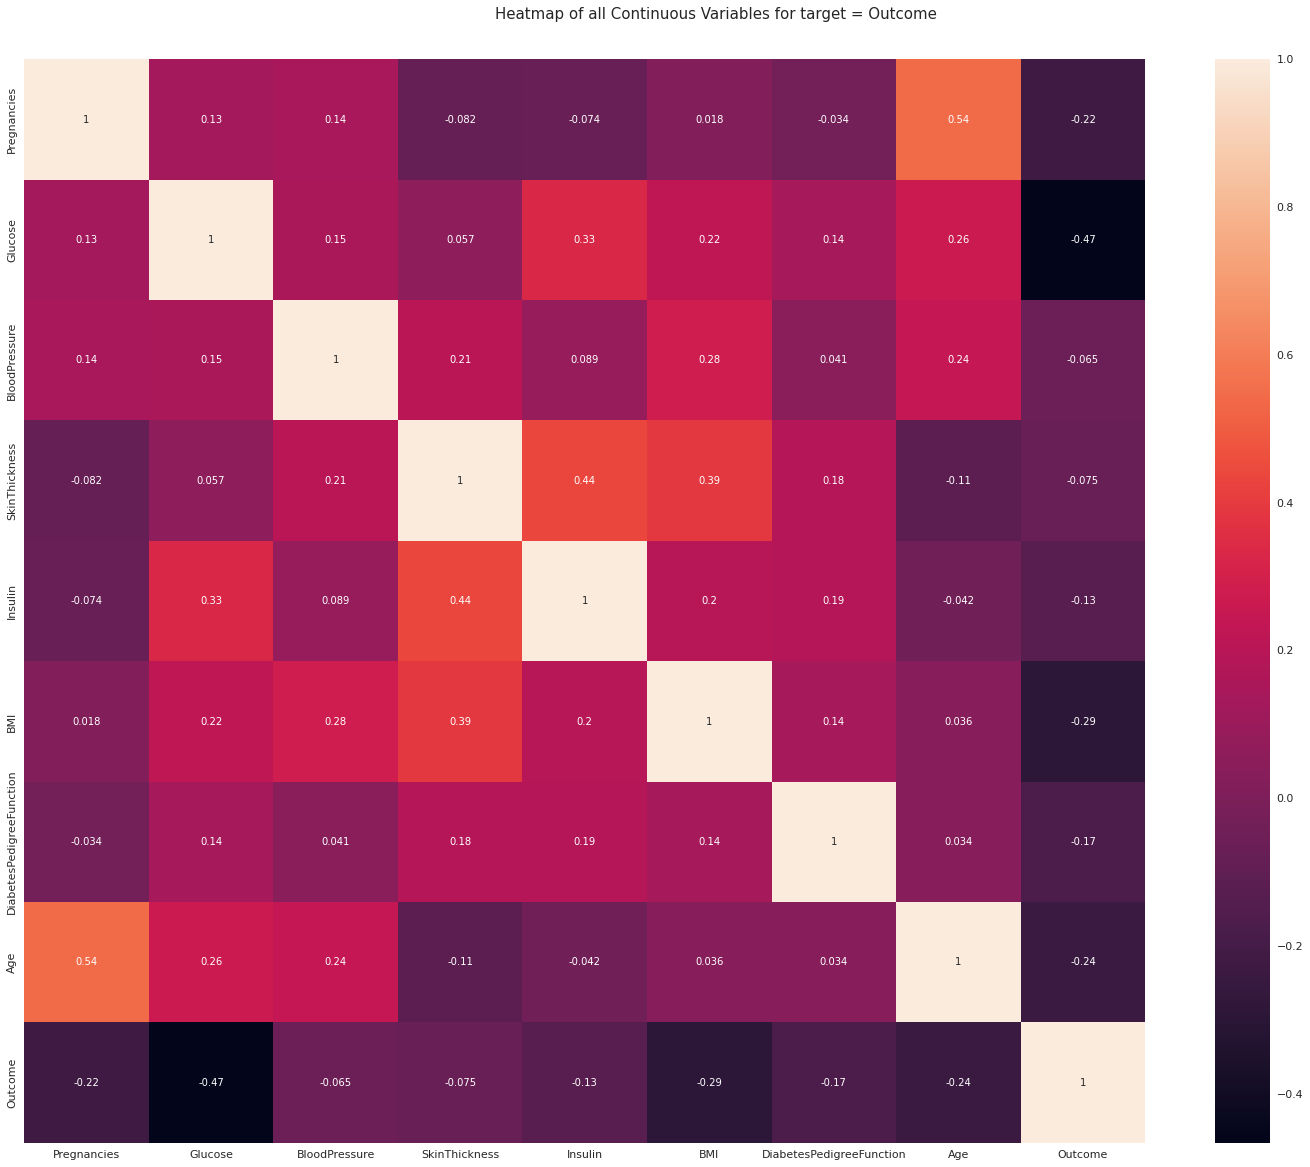

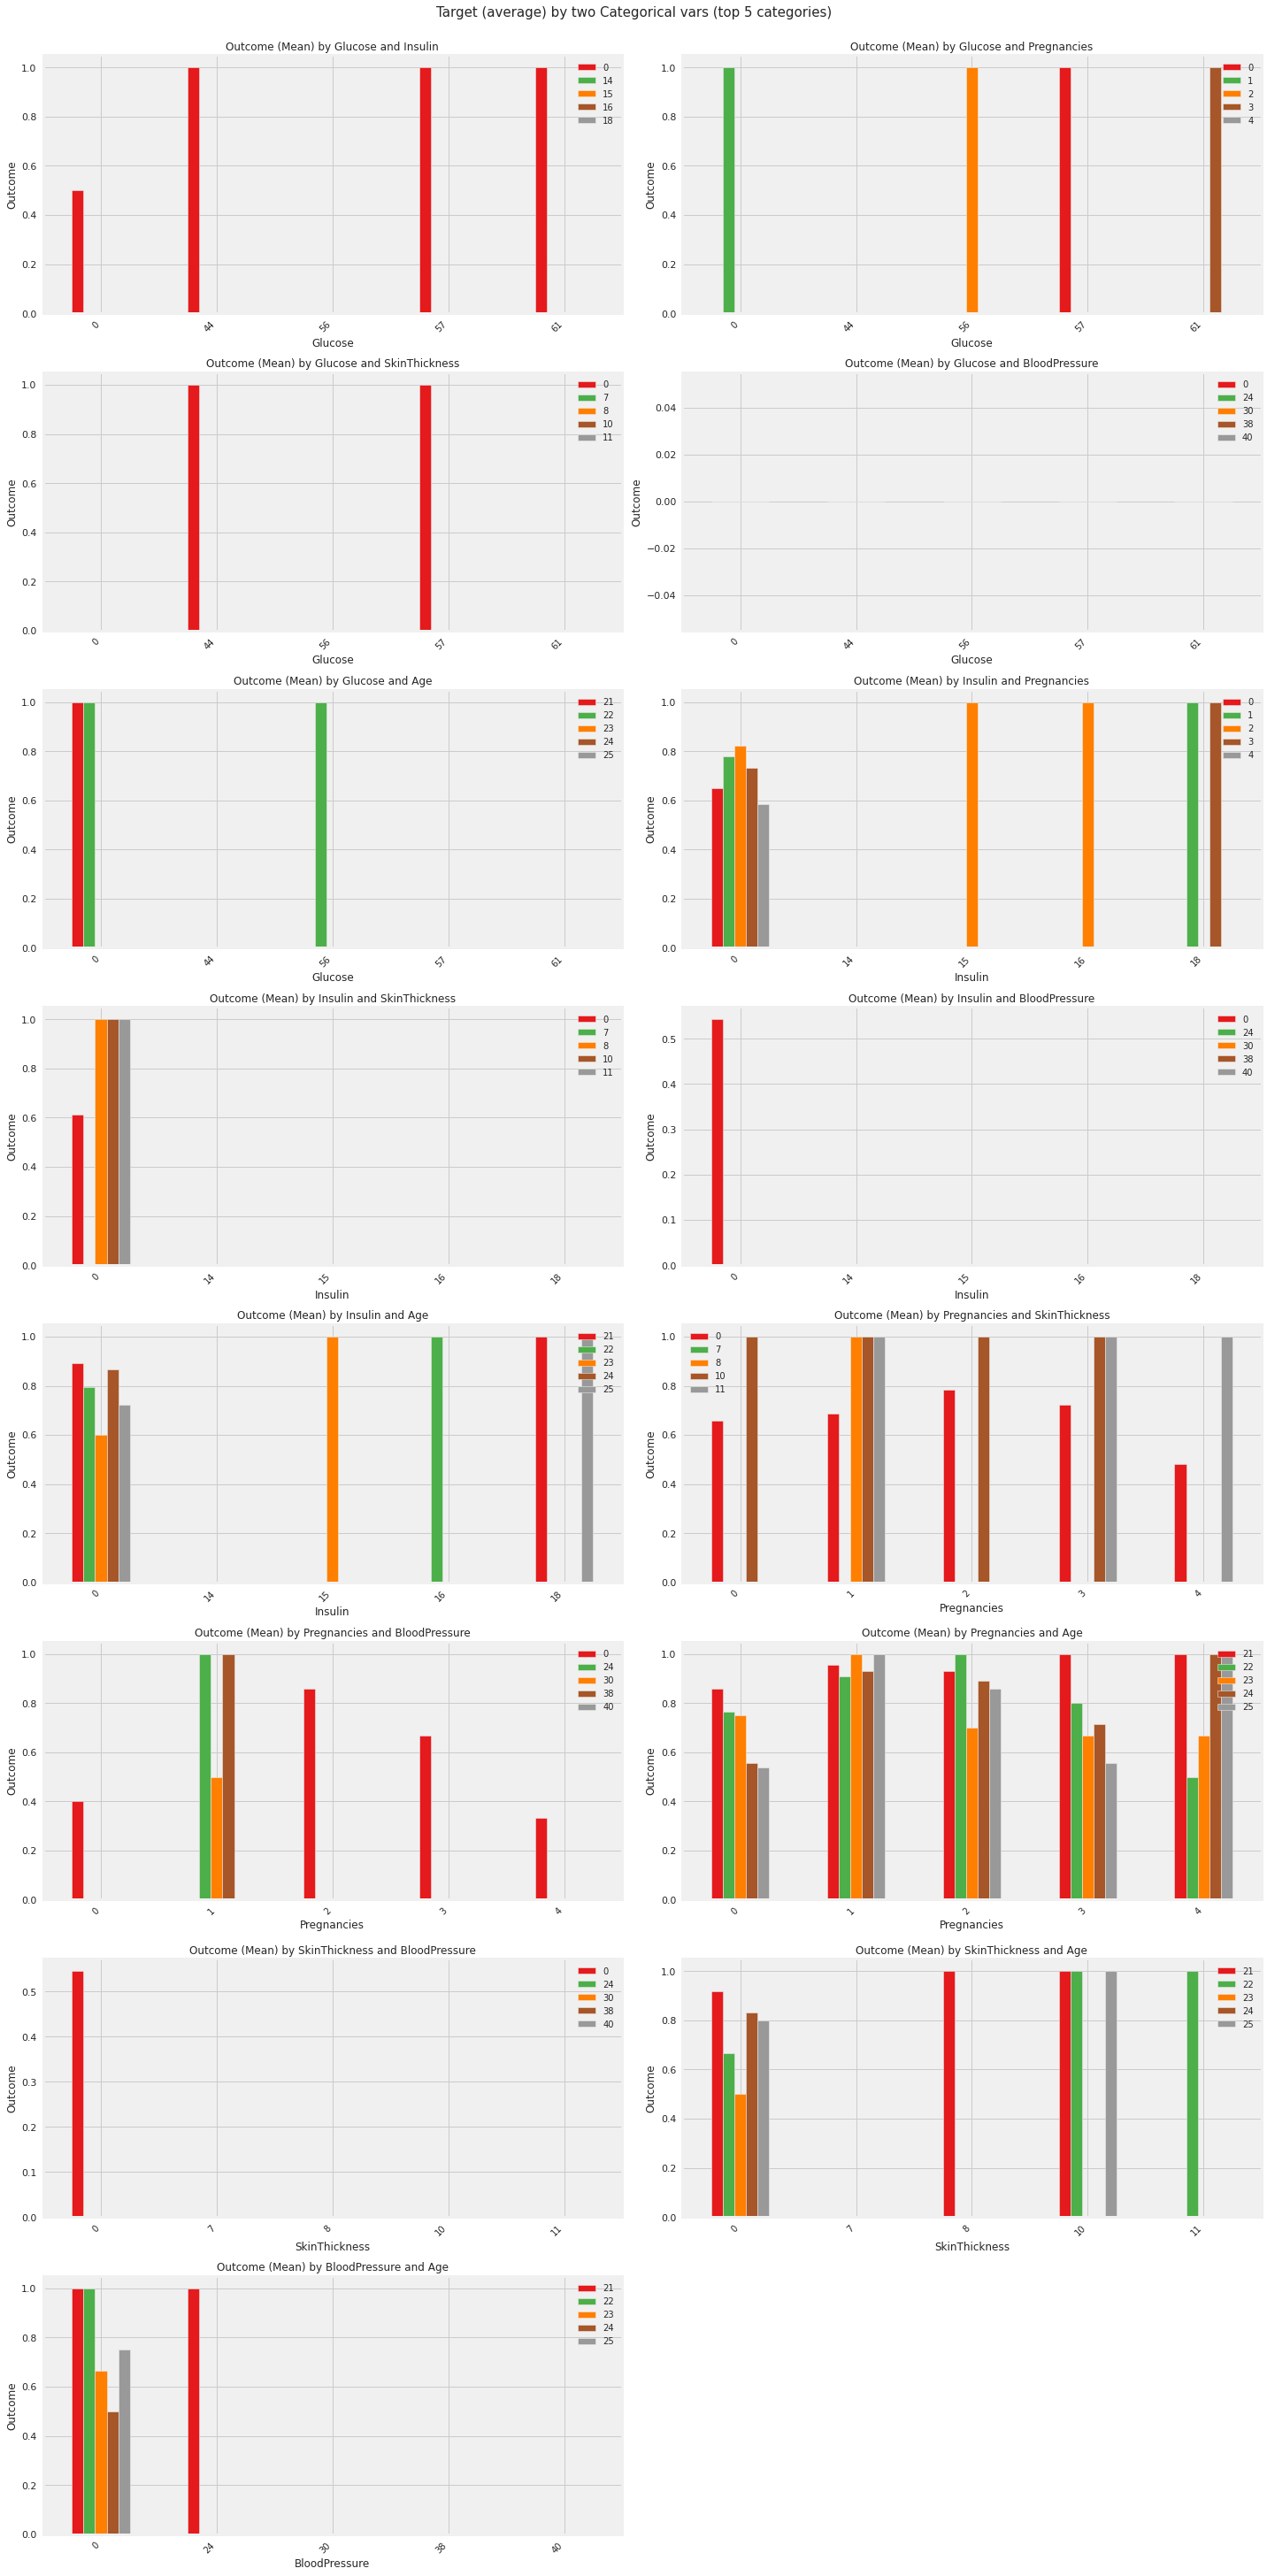

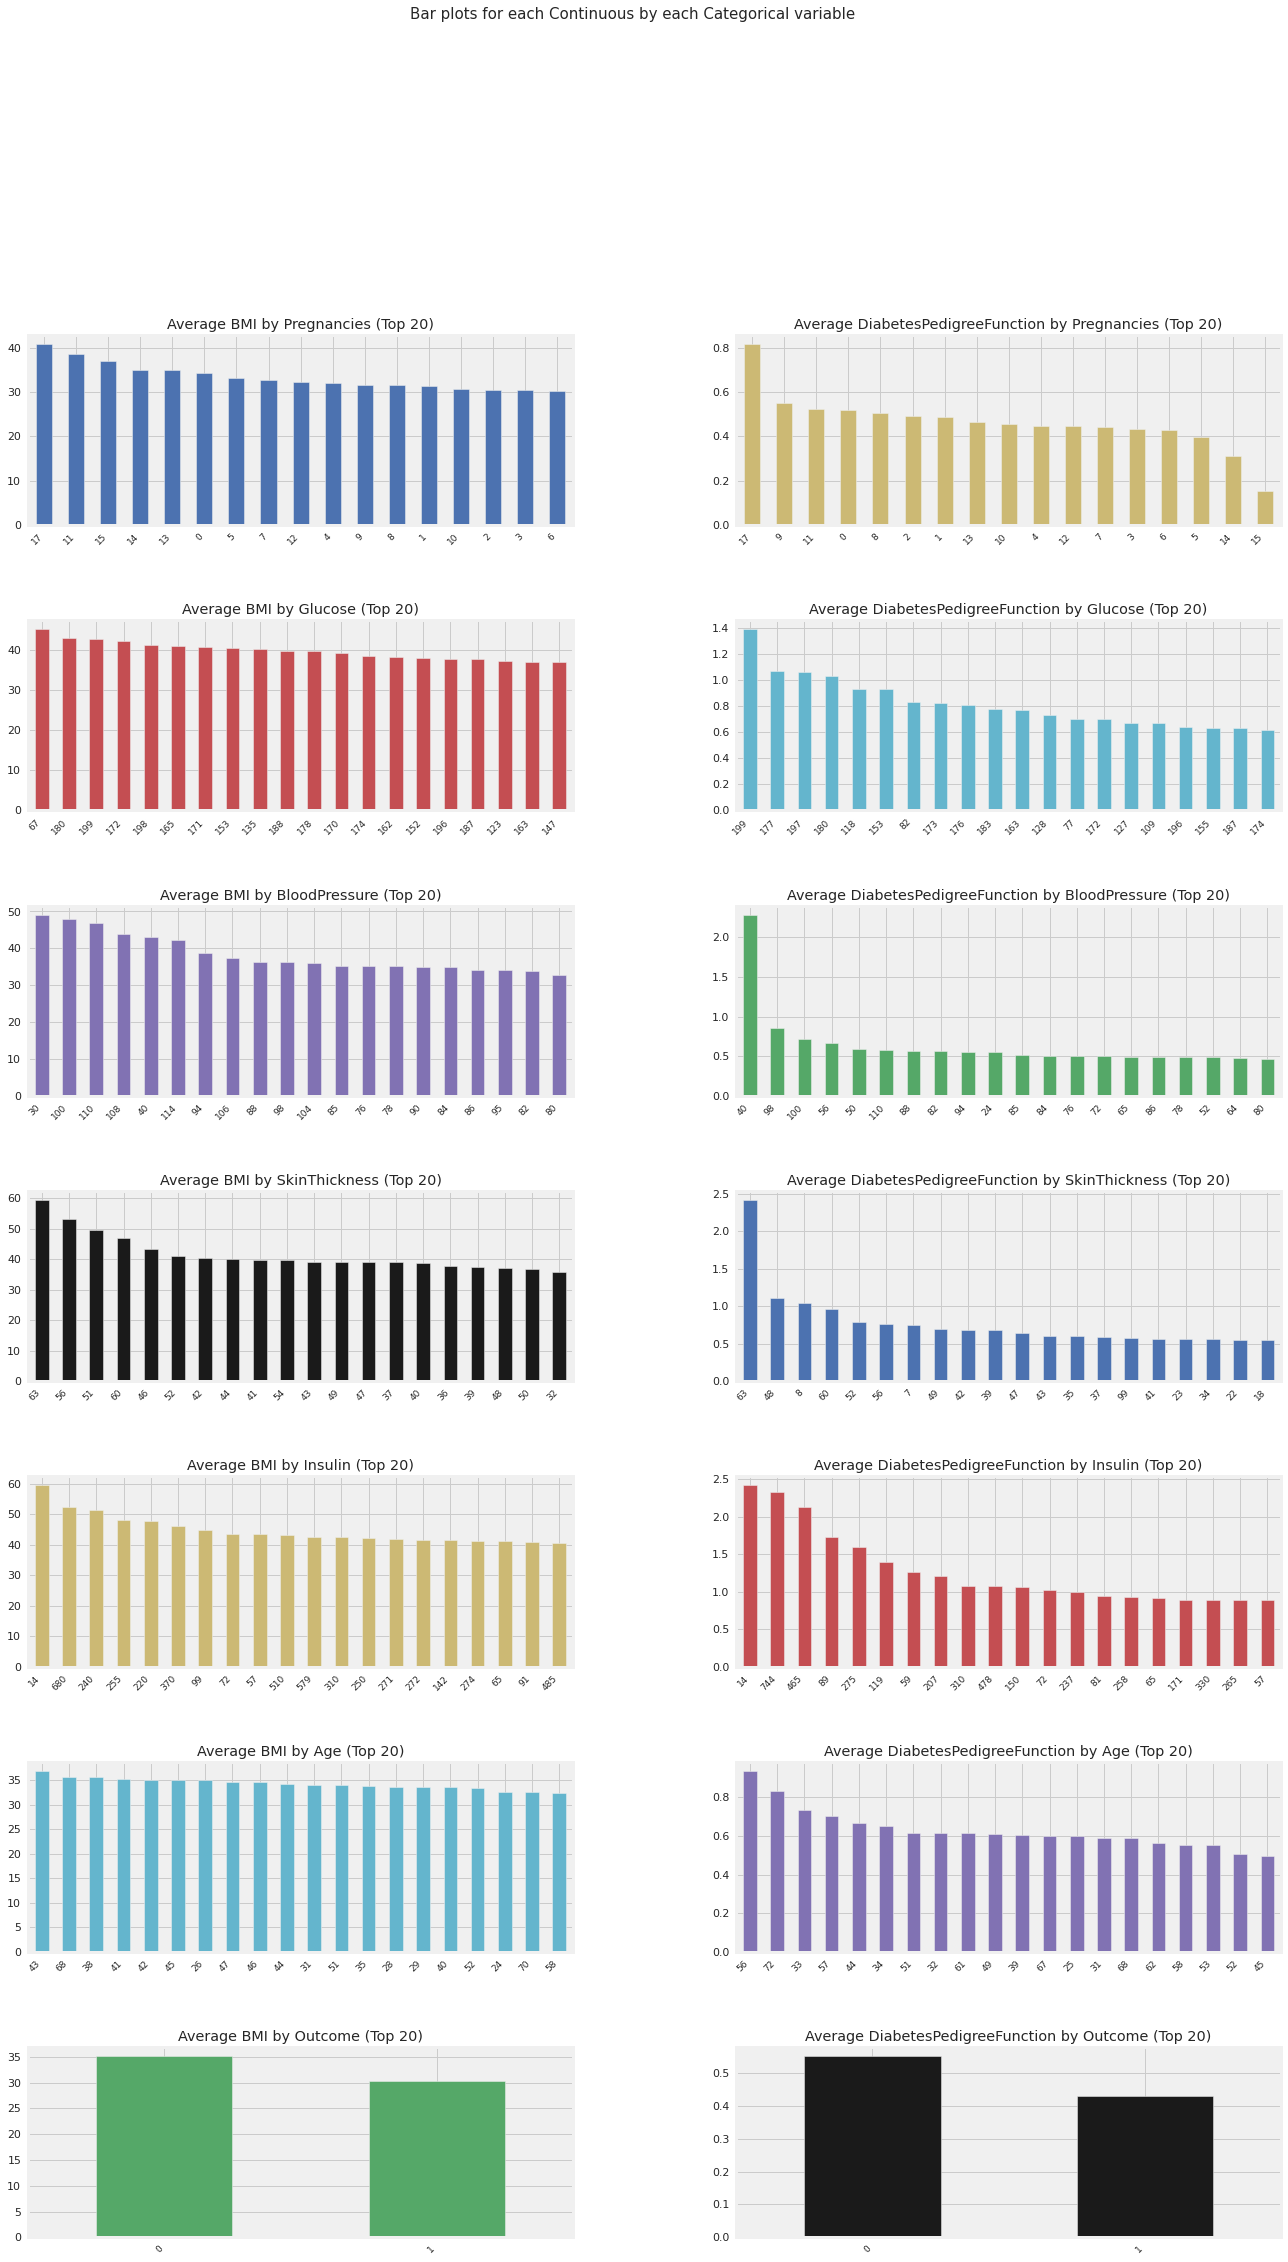

All Plots done
Time to run AutoViz = 13 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [38]:
eda(display_format="inline")

**Classification**

For performing classification on this dataset, I needed to run `compare_models()` to find which models will perform the best based on the data I provided. For classification, PyCaret allows the user to compare the performance of 14 different models, as seen above. This trains and uses cross validation to evaluate the performance of every model in the library. 

To select a model, a user can automatically store the best model, in terms of accuracy, in a variable by assigning the function call to a variable like so:
`best = compare_models`
However, given the domain here, I chose to manually select the model that produced the best recall, as a false negative is the outcome we wanted to avoid the most.


In [9]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7597,0.8116,0.6161,0.6694,0.6369,0.4583,0.4630,0.108
lr,Logistic Regression,0.7539,0.8204,0.5456,0.6841,0.6022,0.4282,0.4372,0.707
ridge,Ridge Classifier,0.7521,0.0000,0.5345,0.6841,0.5960,0.4218,0.4310,0.015
rf,Random Forest Classifier,0.7502,0.8160,0.5608,0.6810,0.6062,0.4264,0.4371,0.500
lda,Linear Discriminant Analysis,0.7484,0.8140,0.5342,0.6742,0.5912,0.4141,0.4229,0.017
gbc,Gradient Boosting Classifier,0.7466,0.8189,0.6164,0.6612,0.6263,0.4364,0.4463,0.132
et,Extra Trees Classifier,0.7412,0.8114,0.5032,0.6817,0.5720,0.3929,0.4069,0.458
knn,K Neighbors Classifier,0.7335,0.7708,0.5781,0.6274,0.5973,0.3998,0.4034,0.115
lightgbm,Light Gradient Boosting Machine,0.7203,0.7906,0.5737,0.6201,0.5854,0.3774,0.3856,0.113
dt,Decision Tree Classifier,0.7077,0.6690,0.5459,0.6013,0.5642,0.3458,0.3526,0.015


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1974)
INFO:logs:compare_models() succesfully completed......................................


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1974)

To fully create the model, I called `create_model(“gbc”)` as seen below. In one step, `create_model()` both trains and evaluates the model by using cross validation. Each value in the grid returned are CV scores separated by fold.


In [ ]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8812,0.5556,0.9091,0.6897,0.5846,0.6177
1,0.7963,0.8904,0.8889,0.6400,0.7442,0.5823,0.6040
2,0.7407,0.7714,0.5789,0.6471,0.6111,0.4176,0.4190
3,0.7407,0.7955,0.5263,0.6667,0.5882,0.4028,0.4088
4,0.8148,0.9143,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.8148,0.8496,0.6316,0.8000,0.7059,0.5735,0.5820
6,0.7222,0.7910,0.5789,0.6111,0.5946,0.3836,0.3839
7,0.5849,0.6698,0.3333,0.3750,0.3529,0.0489,0.0491
8,0.6981,0.8444,0.6667,0.5455,0.6000,0.3614,0.3661


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1974, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


To tune the hyperparameters in the model so that it returns the best results, I called the `tune_model()` function. This function alters the hyperparameters in the model to improve its performance based on the `optimise` parameter. As discussed above, I selected recall as that is the most relevant to this project.


In [ ]:
tuned_gbc = tune_model(gbc, optimize="Recall")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8704,0.8951,0.7222,0.8667,0.7879,0.6957,0.7016
1,0.7222,0.8426,0.5556,0.5882,0.5714,0.3662,0.3665
2,0.7778,0.7684,0.6842,0.6842,0.6842,0.5128,0.5128
3,0.7037,0.7820,0.4737,0.6000,0.5294,0.3175,0.3223
4,0.8148,0.8556,0.7368,0.7368,0.7368,0.5940,0.5940
5,0.7778,0.8226,0.5789,0.7333,0.6471,0.4882,0.4954
6,0.7963,0.8256,0.7368,0.7000,0.7179,0.5587,0.5591
7,0.6415,0.6762,0.3333,0.4615,0.3871,0.1430,0.1468
8,0.6981,0.6889,0.6667,0.5455,0.6000,0.3614,0.3661


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=11,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.5, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0, n_estimators=110,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1974, subsample=0.2, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


### Plotting Performance

PyCaret offers a `plot_model()` function, this allows a user to visualise the performance of the model that they have chosen and tuned. I opted to view the confusion matrix and the learning curve. This was that so I could see how many false negatives there were and to see if there was any overfitting.


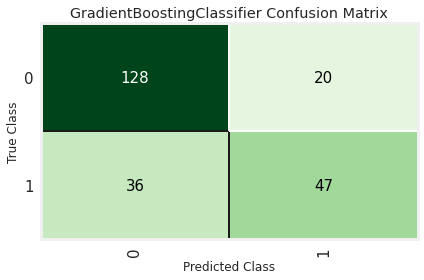

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(gbc, "confusion_matrix")

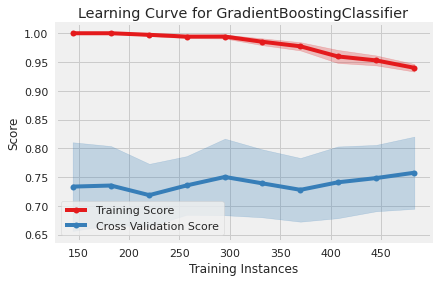

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(gbc, "learning")

Clustering with AutoML and PyCaret is quite different to classification in that there is a human-in-the-loop step to deciding what model to use specifically. I called the `create_model()` function. The list of possible parameters for this function are as follows:

 ‘kmeans’ - K-Means Clustering

‘ap’ - Affinity Propagation

‘meanshift’ - Mean shift Clustering

‘sc’ - Spectral Clustering

‘hclust’ - Agglomerative Clustering

‘dbscan’ - Density-Based Spatial Clustering

‘optics’ - OPTICS Clustering

‘birch’ - Birch Clustering

‘kmodes’ - K-Modes Clustering

Clustering has `tune_model()` and `plot_model()` functions which are similar to the respective functions mentioned above for **Classification**.


### Discussion

In this case, the performance of my hand engineered random forest model was slightly but not insignificantly better than the automated approach, which suggested a Gradient Boosting Machine model.
.As mentioned above, the main performance metric I was focused on as a measure of model skill was *recall*, due to the fact that  a false negative (saying a diabetic patient was healthy) was the most undesirable outcome. With my testing, the random forest model produced a recall of *~0.63* and the autoML solution produced a recall of *~0.61*
In terms of the difference in implementation, the autoML approach was naturally easier to implement and note the performance. Having a way of running 14 different machine learning algorithms with one function call and compare the various performance metrics was useful.

However I did prefer to perform the exploratory data analysis manually as I could personally decide exactly the best way for me to gather insight from the data before building the model. For example, I preferred to decide whether to impute medians or means for each individual column to improve performance, something I was unable to do with the AutoML approach.
The benefit of the AutoML approach to EDA, however, is that one can instantly see relationships between every column to understand the effect a column has on the outcome. From a perspective of purely seeking information on how each feature will affect the target variable, I think the AutoML `eda()` function is optimal.

For training the model itself, both approaches have their advantages and disadvantages. Some advantages of the hand engineered approach are that I could hand-pick possible hyperparameters for hyperparameter tuning. The disadvantage of this is that it could potentially lead to over-fitting, due to a user being **too** hands-on. The advantage of the AutoML approach with PyCaret here, is that it’s quite hard to be overly specific in defining the values of these hyperparameters, thus preventing overfitting to a degree. Some other advantages naturally include how easy it is to compare multiple algorithms to decide which is the best one for this problem.

**Evaluation of the Approaches**

The Random Trees model produced an accuracy of **77.9%** and a recall of **63.2%**. I have some theories on how this could be improved.

* With a better knowledge of the domain, I could have assigned more accurate labels to the features, to improve the decision-making of the trees in the random forest.
* When I imputed the means and medians, I could have assigned different values based on the *Outcome* variable. By not doing this I, made it impossible for the Random Forest model to make a decision for the Outcome based on this feature.  

The AutoML Gradient Boosting Machine produced an accuracy of **75.95%** and a recall of **60.99%**. I think this could also have been improved.
* Some of the classification models would have seen a better performance with normalised data. Additionally, I could have used clustering to compare more models, had I normalised the data.


### References

[1]Smith, Jack, et al. Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus.



[2]CDC. “Defining Adult Overweight & Obesity.” Centers for Disease Control and Prevention, 3 June 2022, www.cdc.gov/obesity/basics/adult-defining.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.. Accessed 4 Oct. 2022.

[3] “Different Types of Blood Sugar Levels You Should Know!” PharmEasy Blog, 28 Feb. 2022, pharmeasy.in/blog/understanding-blood-sugar-level-numbers/#:~:text=Normal%20reading%20%E2%80%93%20less%20than100%20mg,reading%20%E2%80%93%20above%20126%20mg%2Fdl. Accessed 5 Oct. 2022.

‌

‌